# Monotone dependency modeling

Sometimes all we know for certain data is that there is some growth or drop, but we are not certain of the exact functional form.

In [7]:
import scipy as sp
import scipy.stats
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
plt.style.use('seaborn-whitegrid')

### Simulatiing data

For demonstration purposes, we will simulate data that has monotone growth, let's say $f(x) = arctan(x)$, in the range $[0, 5]$ and add some Gaussian noise around those observations:

$$ x \sim Uniform(0, 5) $$

$$ y \sim \text{Normal}(\arctan(x), 0.07^2) $$

In [2]:
data = pd.DataFrame(dict(x = sp.stats.uniform(0, 5).rvs(50)))
data = data.assign(y = np.arctan(data.x) + sp.stats.norm(0, 0.07).rvs(50))
data = data.sort_values('x').reset_index(drop=True)
data.sample(5)

,x,y
12,0.970245,0.809870
26,2.821841,1.151914
37,3.643073,1.294841
23,2.094008,1.175540
22,1.977773,1.137424


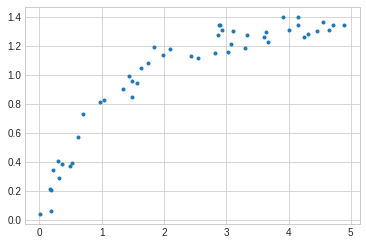

In [3]:
plt.scatter(data.x, data.y, marker='.')
None

## Model

We will model the data so that the $x$ values cummulatively apply an effect to the outcome, so that the largest $x$ value corresponds to a maximum effect:

$$ y_i = a + b\sum_{j=1}^i\delta_j$$

$$ \sum_{j=1}^{N}\delta_j = 1 $$

Here, $y_0 = a$ corresponds to $\min(x)$ and $y_{N-1} = b$ to ${\max(x)}$. 

For $\delta$, luckily, we have a distribution that satisfies exactly that criterion:



$$ \delta \sim \text{Dirichlet}(a=\mathbf{1}) $$

where we set the concentration parameter $a=\mathbf{1}$, which is considered to be non-informative prior.

Choosing priors, we can select a weakly informative prior for a:

$$ a \sim \text{Normal}(0, 0.5^2) $$

For $b$, however, we should select a prior that is strictly positive, because we model growth:

$$ b \sim \text{HalfNormal}(1^2) $$

For the observed data, we will use normal likelihood with Cauchy prior for the noise:

$$ \text{observed} \sim \text{Normal}(y, \varepsilon^2) $$

$$ \varepsilon \sim \text{HalfCauchy}(\beta=1) $$

In [21]:
with pm.Model() as m1:
    N = data.shape[0]

    a = pm.Normal('a', 0, 0.5)
    b = pm.HalfNormal('b', 1)
    delta = pm.Dirichlet('delta', np.ones(N-1))

    _cur = 0
    partial_sum = [0]
    for i in range(N-1):
        _cur = _cur + delta[i]
        partial_sum.append(_cur)

    partial_sum = pm.Deterministic('partial_sum', pm.math.stack(partial_sum))

    y = pm.Deterministic('y', a + b * partial_sum)

    eps = pm.HalfCauchy('eps', beta=0.1)
    obs = pm.Normal('obs', y, eps,
                    observed=data.y.values)

    m1.trace = pm.sample(5000, tune=5000, chains=2)

<ipython-input-21-72c5546b3e91>:22: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  m1.trace = pm.sample(5000, tune=5000, chains=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [eps, delta, b, a]


Sampling 2 chains for 5_000 tune and 5_000 draw iterations (10_000 + 10_000 draws total) took 181 seconds.
There were 2711 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2977 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


Notice how the $x$ values are not used in the inference, the only thing that matters is their order, that is, $x_i < x_{i+1} $ for all.

/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


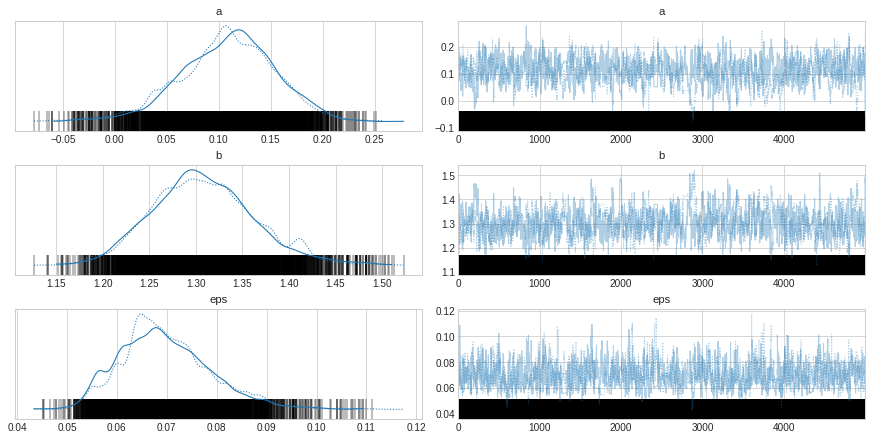

In [22]:
az.plot_trace(m1.trace, var_names=['a', 'b', 'eps'])
None

/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


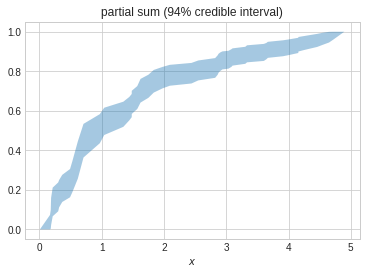

In [23]:
tmp = az.hdi(m1.trace['partial_sum'])
plt.fill_between(data.x, tmp[:, 0], tmp[:, 1], alpha=.4)
plt.gca().set(title='partial sum (94% credible interval)',
              xlabel='$x$')
None

Note that the beginning and the end of the partial sum values are exactly 0 and 1, respectively, by design.

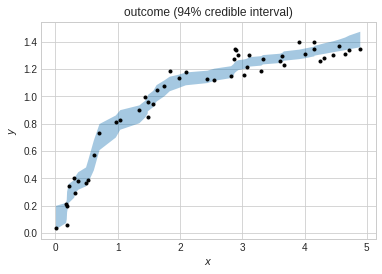

In [24]:
tmp = az.hdi(m1.trace['y'])
plt.fill_between(data.x, tmp[:, 0], tmp[:, 1], alpha=.4)
plt.scatter(data.x, data.y, marker='.', color='k')
plt.gca().set(title='outcome (94% credible interval)',
              xlabel='$x$', ylabel='$y$')
None

/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


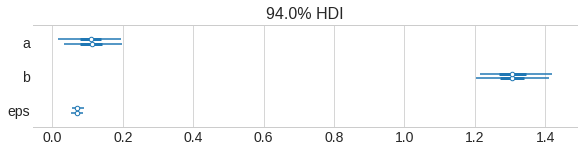

In [25]:
pm.plot_forest(m1.trace, var_names=['a', 'b', 'eps'], figsize=(8, 2))
None

---

In [26]:
with pm.Model() as m_ordered:
    N = data.shape[0]

    a = pm.Normal('a', 2, 2, transform=pm.transforms.ordered, shape=N,
                  testval=np.linspace(-1, 5, N))

    eps = pm.HalfCauchy('eps', beta=0.1)
    obs = pm.Normal('obs', a, eps,
                    observed=data.y.values)

    m_ordered.trace = pm.sample(5000, tune=5000, chains=2)

<ipython-input-26-5a77a3615d78>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  m_ordered.trace = pm.sample(5000, tune=5000, chains=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [eps, a]


Sampling 2 chains for 5_000 tune and 5_000 draw iterations (10_000 + 10_000 draws total) took 79 seconds.
There were 637 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1700 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6987928576894757, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


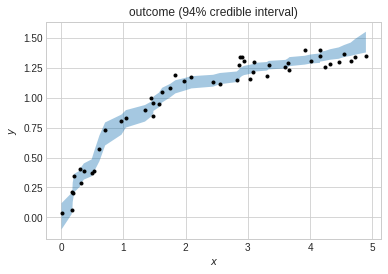

In [27]:
tmp = az.hdi(m_ordered.trace['a'])
plt.fill_between(data.x, tmp[:, 0], tmp[:, 1], alpha=.4)
plt.scatter(data.x, data.y, marker='.', color='k')
plt.gca().set(title='outcome (94% credible interval)',
              xlabel='$x$', ylabel='$y$')
None

In [28]:
az.compare({
    '1': m1.trace,
    '2': m_ordered.trace
}, ic='waic')

/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model wil

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
1,0,58.144085,8.274127,0.000000,1.0,3.52711,0.000000,True,log
2,1,54.667827,9.664630,3.476258,0.0,3.68457,1.978487,True,log
